## Imports

In [171]:
import regex as re
import collections
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import nltk.tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE, KneserNeyInterpolated
from nltk.metrics.agreement import AnnotationTask

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.utils import resample,shuffle
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Janusz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Janusz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Janusz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Defining functions 

In [3]:
def tokenize(text):
    # Initialise lists
    tokens = []
    
    stop_words = set(stopwords.words('english'))
    
    # since we do not use unmatchable it is commented out 
    # unmatchable = []

    # Compile patterns for speedup
    
    token_pat = re.compile(r'[\w|#]+|\p{Emoji}+') # parts of words and emojis
    skippable_pat = re.compile(r'\s+')  # typically spaces
    # Analyze one line at the time as splicing big chunks of text is highly inefficient
    for line in text.split('\n'):
        line = line.casefold()
        # As long as there's any material left...
        while line:
            # Try finding a skippable token delimiter first.
            skippable_match = re.search(skippable_pat, line)
            if skippable_match and skippable_match.start() == 0:
                # If there is one at the beginning of the line, just skip it.
                line = line[skippable_match.end():]
            else:
                # Else try finding a real token.
                token_match = re.search(token_pat, line)
                if token_match and token_match.start() == 0: # If there is one at the beginning of the line, tokenise it.
                    if line[:token_match.end()] != 'user' and line[:token_match.end()] not in stop_words : # skipping censored Twitter handles and stopwords
                        tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
                    
                else:
                    # Else there is unmatchable material here.
                    # It ends where a skippable or token match starts, or at the end of the line.
                    unmatchable_end = len(line)
                    if skippable_match:
                        unmatchable_end = skippable_match.start()
                    if token_match:
                        unmatchable_end = min(unmatchable_end, token_match.start())
                    # Add it to unmatchable and discard from line.
                    # unmatchable.append(line[:unmatchable_end])
                    line = line[unmatchable_end:]

    return tokens

In [4]:
def freq_plot(tokens, voc, idx):
    
    
    frq = pd.DataFrame(voc.most_common(), columns=['token', 'frequency'])

    # Index in the sorted list
    frq['idx'] = frq.index + 1

    # Frequency normalised by corpus size
    frq['norm_freq'] = frq.frequency / len(tokens)

    # Cumulative normalised frequency
    frq['cumul_frq'] = frq.norm_freq.cumsum()
    
    xlabel = 'Index'
    ylabel = 'Cumulative frequency'
    
    fig, axs = plt.subplots(1, 3,figsize=(12,7))
    
    fig.suptitle(idx) 
    
    # Plot: Cumulative frequency by index
    axs[0].scatter(x='idx', y='cumul_frq', data=frq)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    # Plot: Cumulative frequency by index, top 10000 tokens
    axs[1].scatter(x='idx', y='cumul_frq', data=frq[:10000])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    # Plot: Log-log plot for Zipf's law
    
    frq['log_frq'] = np.log(frq.frequency)
    frq['log_rank'] = np.log(frq.frequency.rank(ascending=False))
    
    #x = range(1,len(frq['log_rank']),1)
    #y = range(len(frq['log_rank']),1,-1)
    axs[2].scatter(x='log_rank', y='log_frq', data=frq)
    #y_lim = axs[2].ylim()
    #x_lim = axs[2].xlim()
    #axs[2].plot(x , y , color = 'r')
    #axs[2].ylim(y_lim)
    #axs[2].xlim(x_lim)
    axs[2].set_xlabel("log(rank)")
    axs[2].set_ylabel("log(frequency)")

    
    plt.tight_layout()
    
    fig.show()
    

In [152]:
def read_text(path: str):
    
    val = list()
    text = open(f'../data/{idx}/{path}', 'r', encoding='utf-8').read().splitlines()
        
    for line in text: # divide tweets
        
        val.append(nltk.tokenize.sent_tokenize(line)) # add sentences to tweet list
    
        for i in range(len(val[-1])): # tokenise sentences in the tweet 
        
            val[-1][i] = tokenize(val[-1][i])
    
    return val 

In [6]:
def zips_law_plot():
    # create here a function to plot zip's law, with law line/curve 
    return None

## Tokenisers comparison  

We compare two different tokenisation methods. The one from nltk library and the one provided with the slides I guess. 

In [7]:
tk = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

In [8]:
# each element of this dictionary is a tuple, whose first element is tokens from tokenize()
#and second is from TweetTokenizer()

tokens = dict()
counters = dict() # basically a bag of words 

# indices of the above dictionaries
indices = ['offensive', 'sentiment', 'gatsby']

for idx in indices:
    if idx == 'gatsby':
        # The Great Gatsby has a different path, we also need to remove Gutenberg's header and footer
        text = open('../data/GreatGatsby.txt', 'r', encoding='utf-8').read().split('***')[2]
    else:
        text = open(f'../data/{idx}/train_text.txt', 'r', encoding='utf-8').read()
    tokens[idx] = (tokenize(text), tk.tokenize(text))
    counters[idx] = (collections.Counter(tokens[idx][0]), collections.Counter(tokens[idx][1]))
    
    print(idx.capitalize())
    print('-' * len(idx))
    
    length = len(tokens[idx][0])
    length_counter = len(counters[idx][0])
    print(f"""Our  tokenizer found {length} tokens, {length_counter} of which\
 (or {round(100 * length_counter / length, 2)}%) are unique.""")
    length = len(tokens[idx][1])
    length_counter = len(counters[idx][1])
    print(f"""TweetTokenizer found {length} tokens, {length_counter} of which\
 (or {round(100 * length_counter / length, 2)}%) are unique.\n""")

Offensive
---------
Our  tokenizer found 125030 tokens, 19135 of which (or 15.3%) are unique.
TweetTokenizer found 271264 tokens, 19736 of which (or 7.28%) are unique.

Sentiment
---------
Our  tokenizer found 537228 tokens, 45314 of which (or 8.43%) are unique.
TweetTokenizer found 1015580 tokens, 49124 of which (or 4.84%) are unique.

Gatsby
------
Our  tokenizer found 23634 tokens, 5694 of which (or 24.09%) are unique.
TweetTokenizer found 61266 tokens, 5936 of which (or 9.69%) are unique.



In [9]:
print('20 most common words\n')
for idx in indices:
    print(f'{idx.capitalize()} our tokeniser:')
    for rank, word in enumerate(counters[idx][0].most_common(20), 1):
        print(f'{rank}. {word[0]} - {word[1]} occurences')
    print()    
    
    print(f'{idx.capitalize()} NLTK lib. tokeniser:')
    for rank, word in enumerate(counters[idx][1].most_common(20), 1):
        print(f'{rank}. {word[0]} - {word[1]} occurences')    
    print()

20 most common words

Offensive our tokeniser:
1. liberals - 1245 occurences
2. gun - 1244 occurences
3. control - 1106 occurences
4. like - 1005 occurences
5. antifa - 1004 occurences
6. people - 834 occurences
7. conservatives - 776 occurences
8. #maga - 737 occurences
9. amp - 615 occurences
10. get - 589 occurences
11. one - 574 occurences
12. know - 563 occurences
13. trump - 533 occurences
14. think - 487 occurences
15. would - 472 occurences
16. right - 444 occurences
17. good - 419 occurences
18. time - 353 occurences
19. us - 349 occurences
20. go - 349 occurences

Offensive NLTK lib. tokeniser:
1. . - 12805 occurences
2. the - 8128 occurences
3. is - 5859 occurences
4. to - 5587 occurences
5. a - 4840 occurences
6. you - 4738 occurences
7. and - 4600 occurences
8. ! - 4332 occurences
9. " - 4238 occurences
10. of - 3441 occurences
11. are - 3235 occurences
12. i - 3034 occurences
13. he - 2646 occurences
14. ? - 2638 occurences
15. that - 2534 occurences
16. in - 2427 occuren

<ipython-input-4-432de3536889>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


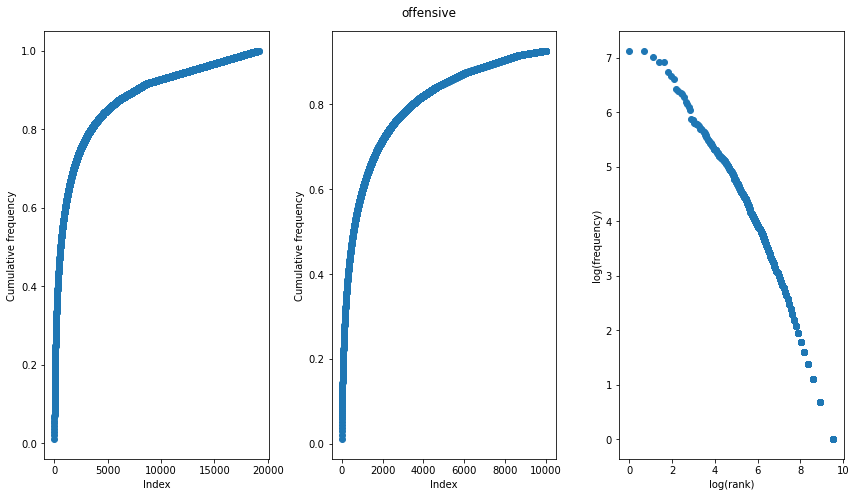

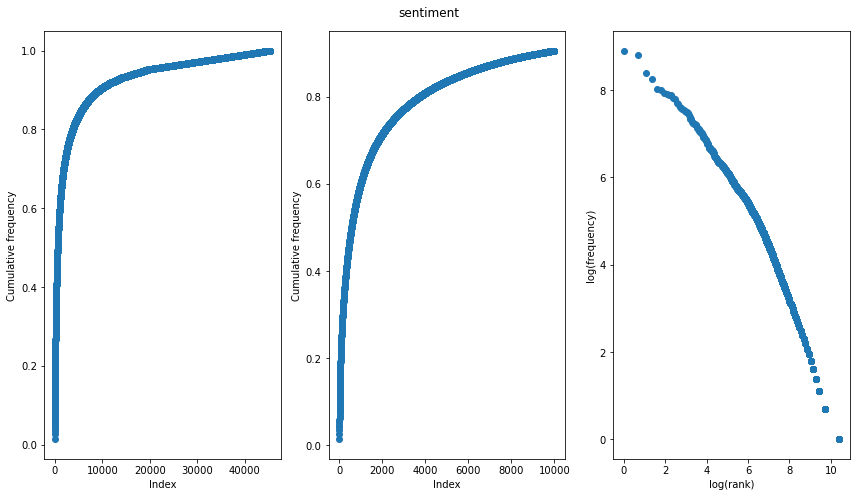

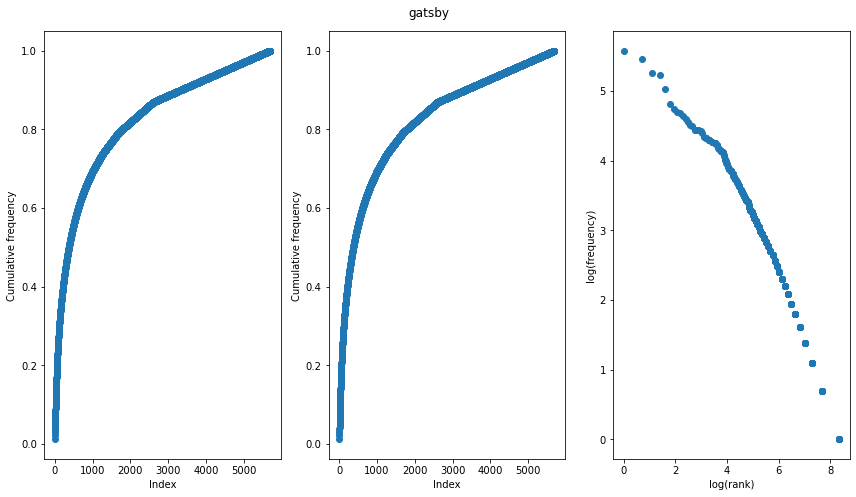

In [10]:
for idx in indices:
    freq_plot(tokens[idx][0], counters[idx][0],idx)


In [11]:
# drop gatsby
if "gatsby" in counters.keys():
    del counters["gatsby"]

if "gatsby" in tokens.keys():
    del tokens["gatsby"]    

indices = ['offensive', 'sentiment']

In [12]:
# drop list at index 1 at all tuples because tweettokenizer generated weird n-grams, for example "!" "!" "!" or "s" "u" "s"
# droping tweet tokeniser results at index 1 
for idx in indices:
    if type(tokens[idx]) == tuple :
        tokens[idx] = tokens[idx][0]
        
    if type(counters[idx]) == tuple :
        counters[idx] = counters[idx][0]
 

In [13]:
#Compare the most frequent words with a general word list for English
wordfre = pd.read_excel(r'../data/wordFrequency.xlsx', sheet_name='1 lemmas')
fre_words = pd.DataFrame(wordfre, columns= ['lemma'])
print("the most frequent words in general word list for English")
print(fre_words.head(20))
print()

for idx in indices:
    print(f'{idx.capitalize()}:')
    for rank, word in enumerate(counters[idx].most_common(20)):
        print(f'{rank}    {word[0]}')
    print()
 

the most frequent words in general word list for English
   lemma
0    the
1     be
2    and
3      a
4     of
5     to
6     in
7      i
8    you
9     it
10  have
11    to
12  that
13   for
14    do
15    he
16  with
17    on
18  this
19   n't

Offensive:
0    liberals
1    gun
2    control
3    like
4    antifa
5    people
6    conservatives
7    #maga
8    amp
9    get
10    one
11    know
12    trump
13    think
14    would
15    right
16    good
17    time
18    us
19    go

Sentiment:
0    tomorrow
1    may
2    u002c
3    day
4    going
5    night
6    see
7    friday
8    sunday
9    1st
10    like
11    time
12    get
13    saturday
14    amp
15    go
16    one
17    2nd
18    new
19    u2019s



In [14]:
# add What types of tokens occur only once, or 2 or 3 times?

## n-grams generation

In [15]:
#xd = list(zip(tokens["offensive"], tokens["offensive"][1:]))
#collections.Counter(xd).most_common(20)

In [16]:
#xd = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:]))
#collections.Counter(xd).most_common(20)

In [17]:
#xd = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:], tokens["offensive"][3:]))
#collections.Counter(xd).most_common(20)

In [18]:
#xd = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:], tokens["offensive"][3:], tokens["offensive"][4:], tokens["offensive"][5:], tokens["offensive"][6:], tokens["offensive"][7:]))
#collections.Counter(xd).most_common(20)

In [19]:
tweets = list()
idx = "offensive"
text = open(f'../data/{idx}/train_text.txt', 'r', encoding='utf-8').read().splitlines()
for line in text: # divide tweets
    tweets.append(nltk.tokenize.sent_tokenize(line)) # add sentences to tweet list
    for i in range(len(tweets[-1])): # tokenise sentences in the tweet 
        tweets[-1][i] = tokenize(tweets[-1][i])
        

In [20]:
tweets[0]

[['bono', 'cares'],
 ['soon',
  'people',
  'understand',
  'gain',
  'nothing',
  'following',
  'phony',
  'celebrity'],
 ['become',
  'leader',
  'people',
  'instead',
  'help',
  'support',
  'fellow',
  'countrymen']]

In [21]:
tweets[6]

[['looking', 'like', 'plant', '#maga', '#walkaway']]

## Max. likelihood evaluation classifier  - perplexity classifier 

In [22]:
lm = [None, None]
for i in range(2, 4): # chnaged 7 to 4
    lm.append(MLE(i))
    train, vocab = padded_everygram_pipeline(i,[item for sublist in tweets for item in sublist])
    lm[i].fit(train, vocab)
    print(f'{i}\n---')
    print(lm[i].generate(10))

2
---
['accuser', '#maga', '#makeamericagreatagain', '</s>', '</s>', 'worst', 'mistake', 'much', '</s>', '</s>']
3
---
['<s>', '<s>', '#danish', 'party', 'wants', 'deport', '#muslims', '#welfare', 'growing', 'fast']


In [23]:
print(lm[2].score("car",["shit"]))
print(lm[2].score("Trump",["idiot"]))

print(lm[2].logscore("car",["shit"]))
print(lm[2].logscore("Trump",["idiot"]))

0.0
0.0
-inf
-inf


In [24]:
val = read_text("val_text.txt")

In [25]:
# # it does not work properly or is just confuding, ask TA about this part of code 
# for i in range(2, 4): # changed 7 to 4 
#     val_test, _ = padded_everygram_pipeline(i, val)
#     for n, t in enumerate(val_test):
#         print(lm[i].perplexity(t))
        

## KneserNeyInterpolated classifier - perplexity classifier 

In [26]:
text = read_text("train_text.txt")

In [27]:
lm = [None, None]
for i in range(2, 4):
    lm.append(KneserNeyInterpolated(i))
    train, vocab = padded_everygram_pipeline(i ,text)
    lm[i].fit(train, vocab)
    print(f'{i}\n---')
    print(lm[i].generate(10))

2
---
['devastates', 'communities', 'across', 'uk', 'control', '</s>', 'polar', 'schizophrenia', 'tough', 'crap']
3
---
['graphics', 'themself', 'spooky', 'hell', 'bright', 'makes', 'nauseous', '</s>', '</s>', '</s>']


In [28]:
print(lm[2].score("car",["shit"]))
print(lm[2].score("Trump",["idiot"]))

print(lm[2].logscore("car",["shit"]))
print(lm[2].logscore("Trump",["idiot"]))

3.1861014607637976e-06
2.868740766240659e-06
-18.259776359394387
-18.411150964464916


In [29]:
val = read_text("val_text.txt")

In [30]:
# for i in range(2, 4): # changed 7 to 4 
#     val_test, _ = padded_everygram_pipeline(i, val)
#     for n, t in enumerate(val_test):
#         print(lm[i].perplexity(t))

In [31]:
# choose some words, calculate for them perplexity in both models and compare them to each other, e.g. attempt to explain such perplexity score was achieved

##  inter-annotator agreement

https://www.nltk.org/_modules/nltk/metrics/agreement.html

In [32]:
manual_labels = [x.split(" ") for x in open('../data/Manual_analysis.txt')]
a = AnnotationTask(manual_labels) # us and provided labels 
manual_labels = manual_labels[:-100] # delete provided labels
provided_labels = manual_labels
u = AnnotationTask(manual_labels) # only us

In [33]:
print(a.avg_Ao()) # degree of agreement Average observed agreement across all coders and items.
print(u.avg_Ao())

0.8099999999999999
0.8350000000000001


In [34]:
print(a.pi()) #Scott 1955; here, multi-pi. Equivalent to K from Siegel and Castellan (1988).
print(u.pi())

0.5676394021590722
0.6125737430659507


## Data preproccesing

- lower case everything 
- divide into sentences 
- punctuation normalization https://towardsdatascience.com/text-normalization-with-spacy-and-nltk-1302ff430119
- n-gram features, stop word lists

## Automatic labeling with ML

In [115]:
# Read the file, convert all elements from strings to integers
off_labels = list(map(int, open('../data/offensive/train_labels.txt', 'r').read().splitlines()))

In [36]:
sum(off_labels)/len(off_labels) * 100

33.07317891910037

## upsampling

In [ ]:
def upsample(df, binary :bool):
    if binary:
        #set the minority class to a seperate dataframe
        df_minor = df[df['label'] == 1]
        #set majority class to another dataframe
        df_major = df[df['label'] != 1]  
        
        if len(df_minor) > len(df_major) :
            df_major, df_minor = df_minor, df_major
       

        #concatenate the upsampled dataframe
        df = pd.concat([resample(df_minor,random_state=42,n_samples=len(df_major),replace=True),df_major])
    

    return(df)

In [105]:
df = pd.DataFrame(off_labels,columns =['label'])
df["tweet"] = tweets
df.head(10)

,label,tweet
0,0,"[bono, cares, soon, people, understand, gain, ..."
1,1,"[eight, years, republicans, denied, obama, pic..."
2,0,"[get, line, help, gonna, fine, game, went, cou..."
3,0,"[great, hi, fiona]"
4,1,"[become, parody, unto, certainly, taken, heat,..."
5,0,"[vetsresistsquadron, bullshit, girl, scout, ve..."
6,1,"[looking, like, plant, #maga, #walkaway]"
7,0,"[lol, except, successful, president, lifetimes..."
8,0,"[willie, fan, since, born, love, holding, rall..."
9,0,"[link, channel, plethora, topics, peruse]"


In [69]:
df = upsample(df, True)

,label,tweet
9657,1,"[see, boobs, lol, 😂😜😘😇]"
10662,1,"[bull, shit, stop, putting, words, people, mou..."
2530,1,"[*, lives, chicago, *, thinks, gun, control, w..."
3886,1,"[little, ass, boy, 🐒]"
3357,1,"[total, phony]"


In [70]:
sum(df["label"])/len(df["label"]) * 100

50.0

In [92]:
df['tweet'][0]

['bono',
 'cares',
 'soon',
 'people',
 'understand',
 'gain',
 'nothing',
 'following',
 'phony',
 'celebrity',
 'become',
 'leader',
 'people',
 'instead',
 'help',
 'support',
 'fellow',
 'countrymen']

In [168]:
def ml_model(path:str):
    
    off_labels = list(map(int, open(f'../data/{path}/train_labels.txt', 'r').read().splitlines()))
    df = pd.DataFrame(off_labels, columns =['label'])
    tweets = open(f'../data/{path}/train_text.txt', 'r',encoding ='utf-8').read().splitlines()
    df["tweet"] = tweets

    off_test_labels = list(map(int, open(f'../data/{path}/test_labels.txt', 'r').read().splitlines()))
    df_test = pd.DataFrame(off_test_labels, columns =['label'])
    tweets =  tweets = open(f'../data/{path}/test_text.txt', 'r',encoding ='utf-8').read().splitlines()
    df_test["tweet"] = tweets

    pipeline = Pipeline([('vect', CountVectorizer()),
                        ('ovs', SMOTE()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', SGDClassifier("log"))])
    
    pipeline.fit(df["tweet"], df["label"])
    predictions = pipeline.predict(df_test["tweet"])
    
    return classification_report(df_test["label"], predictions)

In [170]:
print(ml_model("offensive"))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       620
           1       0.61      0.35      0.45       240

    accuracy                           0.76       860
   macro avg       0.70      0.63      0.65       860
weighted avg       0.74      0.76      0.73       860

